In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import numpy.matlib as matlib
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import support_code

In [2]:
def likelihoodFunc(W , X_train , y_train , likelihood_var) :
    '''
    计算观察样本(X_train , y_train)在给定参数W下的似然值.使用取对数求和最后求对数的方式保留精度,加速运算.
    Args:
        W - 模型参数 , 二维numpy矩阵(num_features , 1)
        X_train - 观测到的训练样本特征 , 二维numpy矩阵(num_instances , num_feautres)
        y_train - 观测到的训练样本输出 , 二维numpy矩阵(num_instances , 1)
        likelihood_var - y ～ N(W.T * x , likelihood_var) 高斯分布对应的方差 , 实数
    Returns:
        likelihood - 似然值 , 实数
    '''
    y_predict = np.matmul(X_train , W)
    log_likelihood = np.sum(-(y_predict - y_train)**2 - np.log(np.sqrt(2 * np.pi) * likelihood_var))
    likelihood = np.exp(log_likelihood)
    return likelihood

def getPosteriorParams(X_train , y_train , prior , likelihood_var = 0.2 ** 2) :
    
    '''
    计算后验概率分布的参数. 根据P(W|(X_train , y_train)) = P((X_train , y_train)|W) * P(W) / P((X_train , y_train))可以
    计算出后验概率符合一个新的高斯分布,其均值向量和协方差矩阵如下:
        postVar = likelihood_var * (X^T * X + likelihood_var * priorVar^{-1})^{-1}
        postMean = (X^T * X + likelihood_var * priorVar^{-1})^{-1} * (X^T * y + likelihood_var * priorVar^{-1} * priorMean)
    注意矩阵的加速计算,选择好合适的结合顺序.
    Args:
        X_train - 观测到的训练样本特征 , 二维numpy矩阵(num_instances , num_feautres)
        y_train - 观测到的训练样本输出 , 二维numpy矩阵(num_instances , 1)
        prior - 先验概率分布的参数 , 字典. 
                prior['mean'] - 均值向量priorMean , 二维numpy矩阵(num_feautres , 1)
                prior['var] - 协方差矩阵priorVar , 二维numpy矩阵(num_feautres , num_features)
        likelihood_var - y ～ N(W.T * x , likelihood_var) 高斯分布对应的方差 , 实数
    Returns:
        postMean:  后验概率均值向量 , 二维numpy矩阵(num_feautres , 1)
        postVar : 后验概率协方差矩阵 , 二维numpy矩阵(num_feautres , num_features)
    '''    
    postVar = (np.matmul(X_train.T , X_train) / (likelihood_var) + prior['var'].getI()).getI()
    b = np.matmul(X_train.T , y_train) + likelihood_var * np.matmul(prior['var'].getI() , prior['mean'])
    A = np.matmul(X_train.T , X_train) + likelihood_var * prior['var'].getI()
    postMean = np.linalg.solve(A , b)
    return postMean, postVar


def getPredictiveParams(X_new , postMean , postVar , likelihood_var = 0.2**2) :
    
    '''
    计算预测概率分布P(y|X,W)的参数,仍然是一个高斯分布. 
        predMean = postMean^T * X_new
        predVar = X_new^T * postVar * X_new + likelihood_var

    Args:
        X_new - 新观测的样本输入特征 , 一维numpy矩阵(num_features)
        postMean:  后验概率均值向量 , 二维numpy矩阵(num_feautres , 1)
        postVar : 后验概率协方差矩阵 , 二维numpy矩阵(num_feautres , num_features)
        likelihood_var - y ～ N(W.T * x , likelihood_var) 高斯分布对应的方差 , 实数
    Returns:
        predMean - 预测概率分布的均值 , 实数
        predVar - 预测概率分布的方差 , 实数
    '''
    predMean = np.matmul(postMean.T , X_new)
    predVar = np.matmul(np.matmul(X_new.T , postVar) , x_new) + likelihood_var

    return predMean, predVar

In [3]:
def generateData(dataSize, noiseParams, actual_weights):
    '''
    生成训练数据.
    '''
    x1 = -1 + 2 * np.random.rand(dataSize, 1)
    X_train = np.matrix(np.c_[np.ones((dataSize, 1)), x1])
    noise = np.matrix(np.random.normal(
                            noiseParams["mean"],
                            noiseParams["var"],
                            (dataSize, 1)))

    y_train = (X_train * actual_weights) + noise

    return X_train, y_train

In [4]:
def make_plots(actual_weights, xtrain, ytrain, likelihood_var, prior, likelihoodFunc, getPosteriorParams, getPredictiveParams):

    showProgressTillDataRows = [1, 2, 10, -1]
    numRows = 1 + len(showProgressTillDataRows)
    numCols = 4
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=.8, wspace=.8)

    plotWithoutSeeingData(prior, numRows, numCols)

    for roundNum, rowNum in enumerate(showProgressTillDataRows):
        current_row = roundNum + 1
        first_column_pos = (current_row * numCols) + 1

        plt.subplot(numRows, numCols, first_column_pos)


        likelihoodFunc_with_data = lambda W: likelihoodFunc(W,
                                                      xtrain[:rowNum,],
                                                      ytrain[:rowNum],
                                                      likelihood_var)
        contourPlot(likelihoodFunc_with_data, actual_weights)

   
        x_seen = xtrain[:rowNum]
        y_seen = ytrain[:rowNum]
        mu, cov = getPosteriorParams(x_seen, y_seen,
                                      prior, likelihood_var)
        posteriorDistr = multivariate_normal(mu.T.tolist()[0], cov)
        posteriorFunc = lambda x: posteriorDistr.pdf(x)
        plt.subplot(numRows, numCols, first_column_pos + 1)
        contourPlot(posteriorFunc, actual_weights)


        dataSeen = np.c_[x_seen[:, 1], y_seen]
        plt.subplot(numRows, numCols, first_column_pos + 2)
        plotSampleLines(mu, cov, dataPoints=dataSeen)


        plt.subplot(numRows, numCols, first_column_pos + 3)
        postMean, postVar = getPosteriorParams(x_seen, y_seen, prior)
        plotPredictiveDistribution(getPredictiveParams, postMean, postVar)


    plt.show()

In [5]:
def plotWithoutSeeingData(prior, numRows, numCols):

    #Blank likelihood
    plt.subplot(numRows, numCols, 1, axisbg='grey')
    plt.title("Likelihood")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-0.9, 0.9])
    plt.ylim([-0.9, 0.9])

   
    priorDistribution = multivariate_normal(mean=prior["mean"].T.tolist()[0],
        cov=prior["var"])
    priorFunc = lambda x:priorDistribution.pdf(x)
    plt.subplot(numRows, numCols, 2)
    plt.title("Prior/Posterior")
    contourPlot(priorFunc)

   
    plt.subplot(numRows, numCols, 3)
    plt.title("Data Space")
    plotSampleLines(prior["mean"], prior["var"])


    plt.subplot(numRows, numCols, 4, axisbg='grey')
    plt.title('Predictive Distribution')
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("")
    plt.ylabel("")

In [6]:
def contourPlot(distributionFunc, actualWeights=[]):

    stepSize = 0.05
    array = np.arange(-1, 1, stepSize)
    x, y_train = np.meshgrid(array, array)

    length = x.shape[0] * x.shape[1]
    x_flat = x.reshape((length, 1))
    y_flat = y_train.reshape((length, 1))
    contourPoints = np.c_[x_flat, y_flat]

    values = list(map(distributionFunc, contourPoints))
    values = np.array(values).reshape(x.shape)

    plt.contourf(x, y_train, values)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.xticks([-0.5, 0, 0.5])
    plt.yticks([-0.5, 0, 0.5])
    plt.xlim([-0.9, 0.9])
    plt.ylim([-0.9, 0.9])

    if(len(actualWeights) == 2):
        plt.plot(float(actualWeights[0]), float(actualWeights[1]),
                 "*k", ms=5)

In [7]:
def plotSampleLines(mean, variance,
                    numberOfLines=6,
                    dataPoints=np.empty((0, 0))):
    stepSize = 0.05
   
    for round in range(1, numberOfLines):
        weights = np.matrix(np.random.multivariate_normal(mean.T.tolist()[0], variance)).T
        x1 = np.arange(-1, 1, stepSize)
        x = np.matrix(np.c_[np.ones((len(x1), 1)), x1])
        y_train = x * weights

        plt.plot(x1, y_train)

    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("x")
    plt.ylabel("y")

    if(dataPoints.size):
        plt.plot(dataPoints[:, 0], dataPoints[:, 1],
                 "co")

In [8]:
def plotPredictiveDistribution(getPredictiveParams,postMean, postVar):
    stepSize = 0.05
    x = np.arange(-1, 1, stepSize)
    x = np.matrix(np.c_[np.ones((len(x), 1)), x])
    predMeans = np.zeros(x.shape[0])
    predStds = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        predMeans[i], predStds[i] = getPredictiveParams(x[i,].T,
                                                        postMean,
                                                        postVar)
    predStds = np.sqrt(predStds)
    plt.plot(x[:,1], predMeans, 'b')
    plt.plot(x[:,1], predMeans + predStds, 'b--')
    plt.plot(x[:,1], predMeans - predStds, 'b--')
    plt.xticks([-1, 0, 1])
    plt.yticks([-0.5, 0, 0.5])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("x")
    plt.ylabel("y")

In [9]:
def Expeiment() :
    '''
    选取不同的先验分布参数,依次增加观测的样本数据,绘制对应图像,观察其后验分布的变化.
    '''
    np.random.seed(46134)
    actual_weights = np.matrix([[0.3], [0.5]])
    dataSize = 40
    noise = {"mean":0, "var":0.2 ** 2}
    likelihood_var = noise["var"]
    X_train, y_train = generateData(dataSize, noise, actual_weights)
    sigmas_to_test = [1/2, 1/(2**5), 1/(2**10)]
    for sigma_squared in sigmas_to_test:
        prior = {"mean":np.matrix([[0], [0]]),"var":matlib.eye(2) * sigma_squared}

        make_plots(actual_weights,
                                X_train,
                                y_train,
                                likelihood_var,
                                prior,
                                likelihoodFunc,
                                getPosteriorParams,
                                getPredictiveParams)

/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


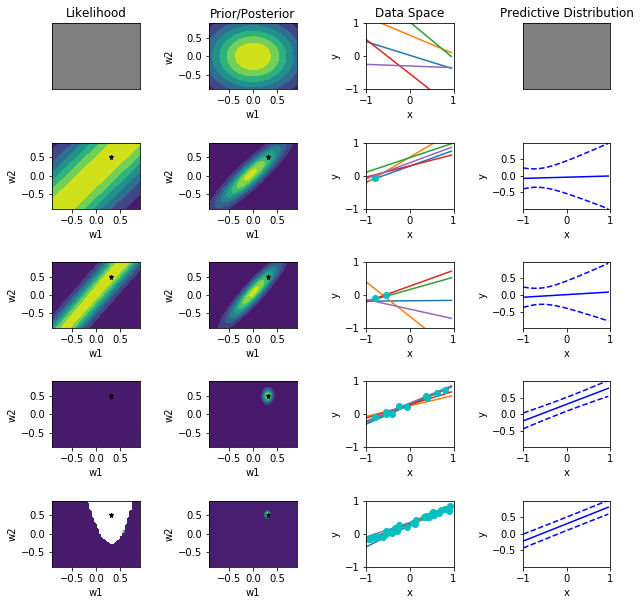

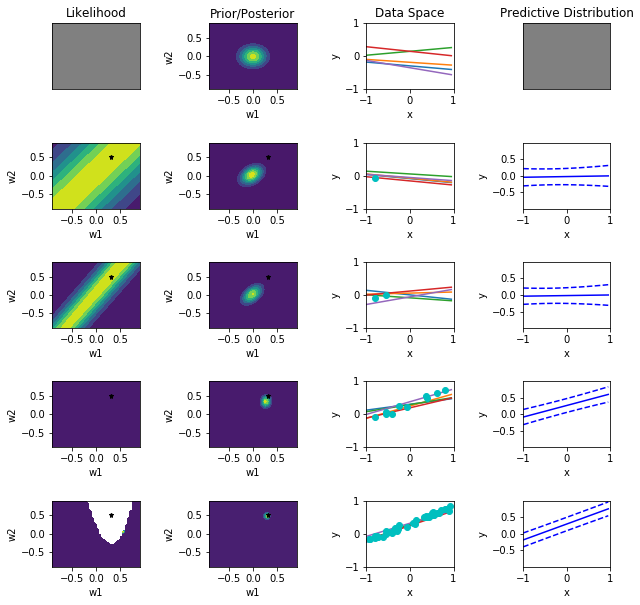

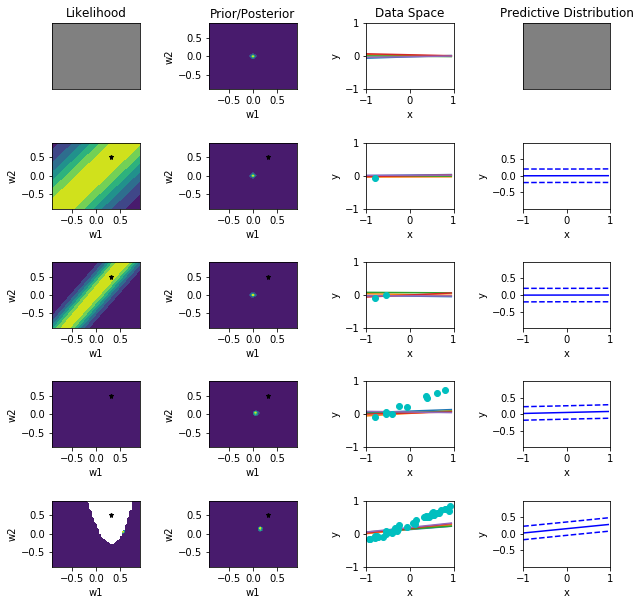

In [10]:
Expeiment()